<a href="https://colab.research.google.com/github/pradnya-git-dev/W22_COMP6321_Project/blob/main/W22_COMP6321_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Installing required modules

In [ ]:
# Installs required modules

!pip install --upgrade watermark blackcellmagic
!pip install datasets
!pip install transformers
!pip install umap-learn
!pip install nlpaug
!pip install "ray[tune]"
!pip install hyperopt

2. Importing required modules

In [2]:
# Loads Black extension and imports required modules
%load_ext blackcellmagic

import torch
from datasets import load_dataset, DatasetDict, Features, Value, ClassLabel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler
from ray import tune
import json
import os
from joblib import dump, load
torch.manual_seed(0)
np.random.seed(0)

3. Defining utility functions for the entire project

In [32]:
def prepare_dataset(working_dir=os.getcwd(), dataset_mode="original"):

  train_file = working_dir + "/train_dataset_processed.csv"
  test_file = working_dir + "/test_dataset_processed.csv"

  if dataset_mode == "augmented":
    train_file = working_dir + "/train_dataset_augmented.csv"
    test_file = working_dir + "/test_dataset_augmented.csv"

  data_files = {"train": train_file, "test": test_file}
  class_names = ["negative", "neutral", "positive"]
  data_columns = Features({"label": ClassLabel(names=class_names), "text": Value("string")})
  original_data = load_dataset("csv", data_files=data_files, column_names=["label", "text"], features=data_columns)

  train_valid_data = original_data["train"].train_test_split(test_size=0.2)
  train_dataset = train_valid_data["train"]
  valid_dataset = train_valid_data["test"]
  project_dataset = DatasetDict({
      "train": train_dataset,
      "valid": valid_dataset,
      "test": original_data["test"]})

  # Removing empty text entries
  project_dataset = project_dataset.filter(lambda example: example["text"] != None)
  return project_dataset


def plot_confusion_matrix(y_preds, y_true, labels, title):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fix, ax = plt.subplots(figsize=(6, 6))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  cm_display.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix for " + title)
  plt.show()

def print_classification_report(y_preds, y_true, title):
  labels = ["negative", "neutral", "positive"]
  plot_confusion_matrix(y_preds, y_true, labels, title)
  print("\n\n")
  print("Classification report for " + title)
  mlp_report = classification_report(y_true, y_preds, target_names=labels)
  print("-" * 75)
  print(mlp_report)
  print("-" * 75)

def display_data_properties(dataset):
  """Checking the data distribution"""
  # Using pandas for checking the data distribution
  dataset.set_format(type="pandas")
  train_df = dataset["train"][:]
  valid_df = dataset["valid"][:]
  test_df = dataset["test"][:]

  # Printing the first 5 examples in the train data
  def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

  train_df["label_name"] = train_df["label"].apply(label_int2str)
  valid_df["label_name"] = valid_df["label"].apply(label_int2str)
  test_df["label_name"] = test_df["label"].apply(label_int2str)
  print(train_df.head())

  # Displaying the frequency of classes in the training data
  train_df["label_name"].value_counts(ascending=True).plot.barh()
  plt.title("Frequency of Classes in training data")
  plt.show()
  plt.figure()
  valid_df["label_name"].value_counts(ascending=True).plot.barh()
  plt.title("Frequency of Classes in validation data")
  plt.show()
  plt.figure()
  test_df["label_name"].value_counts(ascending=True).plot.barh()
  plt.title("Frequency of Classes in test data")
  plt.show()

  # Resetting the dataset format
  dataset.reset_format()

# display_data_properties(dataset)

# 2. Transformers section

## 2.1. Completing project setup for transformer models

In [5]:
working_dir = os.getcwd()   # Sets the working directory for the project
project_dataset = prepare_dataset()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_samples = [9023, 12366, 6416]
class_weights = [1 - (x / sum(class_samples)) for x in class_samples]
class_weights = torch.FloatTensor(class_weights).to(device)

model_checkpoint = "bert-base-uncased"

if not os.path.exists(working_dir + "/output-" + model_checkpoint):
  os.makedirs(working_dir + "/output-" + model_checkpoint)
model_output_dir = working_dir + "/output-" + model_checkpoint

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Using custom data configuration default-69642fa7cbba2f3e


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-69642fa7cbba2f3e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

## 2.2 Preparing input data

2.2.1. Tokenizating the input

In [21]:
def encode_dataset(tokenizer, project_dataset):
  
  # Initializing the tokenizer
  tokenizer = tokenizer

  # Defining tokenization function
  def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
    
  # Applying the tokenize function across all the datasets (train/validation/test)
  return project_dataset.map(tokenize, batched=True, batch_size=None)

dataset_encoded = encode_dataset(tokenizer, project_dataset)

  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-69642fa7cbba2f3e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0fe07723b3adce4e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-69642fa7cbba2f3e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-dcd87247bf9ed598.arrow


## 2.3 Training a classifier

### 2.3.1 Training a classifier using feature extraction

2.3.1.1 Extracting the last hidden states

In [37]:
def extract_hidden_states_features(model_checkpoint, dataset_encoded):

  model = AutoModel.from_pretrained(model_checkpoint).to(device)

  # Extracting the last hidden states
  def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
      last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

  # Extracting hidden states across all dataset splits in one go
  dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
  dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

  return dataset_hidden

dataset_hidden = extract_hidden_states_features(model_checkpoint, dataset_encoded)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

2.3.1.2 Creating train, validation, test datasets of the hidden states as required for the classifier

In [38]:
# Creating a feature matrix
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["valid"]["hidden_state"])
X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["valid"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])

2.3.1.3 Training an MLP classifier using the hidden states and labels

In [ ]:
mlp = MLPClassifier(random_state=0,
                    validation_fraction=0.2, 
                    early_stopping=True)
mlp.fit(X_train, y_train)
print("Training accuracy: %.2f %%" % (mlp.score(X_train, y_train) * 100))
print("Validation accuracy: %.2f %%"  % (mlp.score(X_valid, y_valid) * 100))

2.3.1.4 Generating results to document a baseline

Plots the training loss and validation accuracy of the MLP model

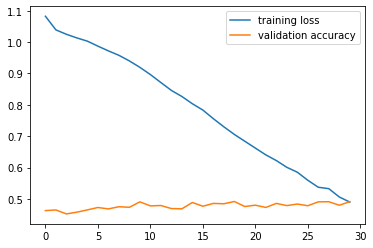

In [47]:
plt.plot(mlp.loss_curve_, label="training loss")
plt.plot(mlp.validation_scores_, label="validation accuracy")
plt.legend();

Provides the confusion matrix and classification report for validation data and test data of the project

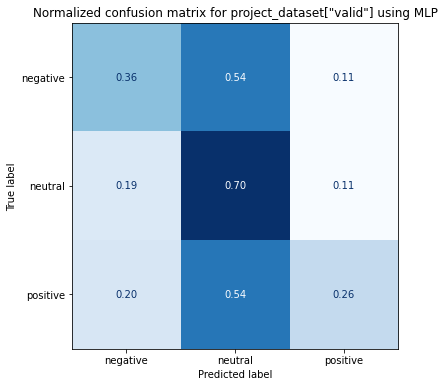




Classification report for project_dataset["valid"] using MLP
---------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.48      0.36      0.41      1834
     neutral       0.51      0.70      0.59      2446
    positive       0.42      0.26      0.32      1282

    accuracy                           0.49      5562
   macro avg       0.47      0.44      0.44      5562
weighted avg       0.48      0.49      0.47      5562

---------------------------------------------------------------------------


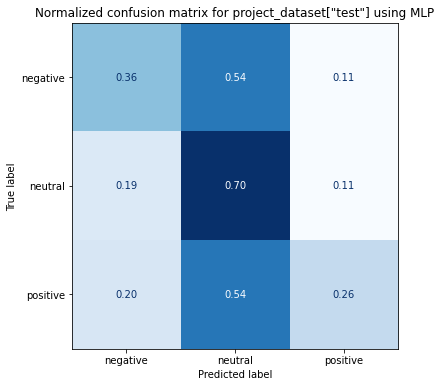




Classification report for project_dataset["test"] using MLP
---------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.44      0.37      0.40       504
     neutral       0.28      0.50      0.36       384
    positive       0.51      0.23      0.31       413

    accuracy                           0.36      1301
   macro avg       0.41      0.37      0.36      1301
weighted avg       0.41      0.36      0.36      1301

---------------------------------------------------------------------------


In [76]:
y_preds_v = mlp.predict(X_valid)
print_classification_report(y_preds_v, y_valid, "project_dataset[\"valid\"] using MLP")

y_preds_t = mlp.predict(X_test)
print_classification_report(y_preds_t, y_test, "project_dataset[\"test\"] using MLP")

2.3.1.5 Saving the trained model

In [83]:
mlp_save_filename = working_dir + "/mlp.joblib"
dump(mlp, mlp_save_filename)

['/content/mlp.joblib']

2.3.1.5 Loading saved model and testing performance on test data

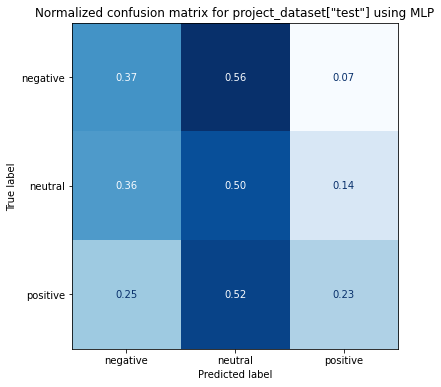




Classification report for project_dataset["test"] using MLP
---------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.44      0.37      0.40       504
     neutral       0.28      0.50      0.36       384
    positive       0.51      0.23      0.31       413

    accuracy                           0.36      1301
   macro avg       0.41      0.37      0.36      1301
weighted avg       0.41      0.36      0.36      1301

---------------------------------------------------------------------------


In [39]:
loaded_mlp = load(working_dir + "/best_models/mlp/mlp.joblib")
y_preds_t = loaded_mlp.predict(X_test)
print_classification_report(y_preds_t, y_test, "project_dataset[\"test\"] using MLP")

### 2.3.2 Training a classifier using fine tuning

2.3.2.1 Defining functions required for training a classifier by fine-tuning a transformer model

In [7]:
# Defining the performance metrics that will be used to evaluate our model's performance during fine-tuning
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
  loss_val = loss_fct(torch.from_numpy(pred.predictions).to(device), torch.from_numpy(labels).to(device))
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average="weighted")
  prec = precision_score(labels, preds, average="weighted")
  rec = recall_score(labels, preds, average="weighted")
  return {"accuracy": acc, "precision": prec, "recall": rec, "f1_score": f1, "loss": loss_val}


def model_init():
  dropout_val = 0.3
  try:
    with open(model_output_dir + "/model_hp_values.json", "r") as f:
      prev_hp = json.load(f)
      dropout_val = prev_hp["dropout"]
      print("Found previously searched dropout value: ", dropout_val)
  except:
    print("No previous dropout value found. Using default setting of", dropout_val)

  if model_checkpoint == "distilbert-base-uncased":
    return (AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                             num_labels=3, 
                                                             return_dict=True, 
                                                             dropout=dropout_val,
                                                             attention_dropout=dropout_val,
                                                             qa_dropout=dropout_val).to(device))
  elif model_checkpoint == "bert-base-uncased":
    return (AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                             num_labels=3, 
                                                             return_dict=True, 
                                                             attention_probs_dropout_prob=dropout_val,
                                                             hidden_dropout_prob=dropout_val,
                                                             classifier_dropout=dropout_val).to(device))

def compute_objective(metrics):
  return metrics["eval_loss"]

2.3.2.2 Defining the project trainer class

In [8]:
class ProjectTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(output_dir=model_output_dir,
                                  evaluation_strategy="steps",
                                  logging_strategy="steps",
                                  eval_steps=500,
                                  disable_tqdm=False,
                                  logging_dir=model_output_dir + "/logs",
                                  save_total_limit=1,
                                  load_best_model_at_end=True)

trainer = ProjectTrainer(args=training_args,
                            tokenizer=tokenizer,
                            train_dataset=dataset_encoded["train"],
                            eval_dataset=dataset_encoded["valid"],
                            model_init=model_init,
                            compute_metrics=compute_metrics)

No previous dropout value found. Using default setting of 0.3


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.3,
  "classifier_dropout": 0.3,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_v

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
creating metadata file for /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.Laye

2.3.2.3 Performing hyperparameter tuning for the model

In [ ]:
def project_hyperparameter_tuning():

  hp_search_space = dict()
  try:
    with open(model_output_dir + "/model_hp_values.json", "r") as f:
      prev_hp = json.load(f)

    pbs = prev_hp["per_device_train_batch_size"]
    plr = prev_hp["learning_rate"]
    ps = prev_hp["seed"]

    #    "alpha": tune.uniform(0.4,0.8),
    hp_search_space= {
        "per_device_train_batch_size": tune.choice([8, 16, 32, 64]),
        "learning_rate": tune.loguniform(plr * 0.1, plr * 10),
        "weight_decay": tune.choice([0.1, 0.2, 0.3]),
        "num_train_epochs": tune.choice([1, 2, 3, 4, 5])
    }
  except:
    hp_search_space = {
        "per_device_train_batch_size": tune.choice([8, 16, 32, 64]),
        "learning_rate": tune.loguniform(1e-5, 1e-4),
        "weight_decay": tune.choice([0.1, 0.2, 0.3]),
        "num_train_epochs": tune.choice([1, 2, 3, 4, 5])
    }

  if model_checkpoint == "distilbert-base-uncased":
    hp_search_space["dropout"] = tune.uniform(0.1, 0.4)
    hp_search_space["attention_dropout"] = tune.uniform(0.1, 0.4)
    hp_search_space["qa_dropout"] = tune.uniform(0.1, 0.4)
  elif model_checkpoint == "bert-base-uncased":
    hp_search_space["attention_probs_dropout_prob"] = tune.uniform(0.1, 0.4)
    hp_search_space["hidden_dropout_prob"] = tune.uniform(0.1, 0.4)
    hp_search_space["classifier_dropout"] = tune.uniform(0.1, 0.4)

  best_trial = None
  try:
    best_trial = trainer.hyperparameter_search(hp_space=lambda _: hp_search_space,
                                             compute_objective=compute_objective,
                              direction="minimize",
                              backend="ray",
                              n_trials=2,
                              search_alg=HyperOptSearch(metric="objective", mode="min"),
                              scheduler=ASHAScheduler(metric="objective", mode="min"),
                              local_dir=model_output_dir + "/ray_asha_results_bert",
                              log_to_file=True)
    
    hp_values = best_trial.hyperparameters
    hp_values_json = json.dumps(hp_values)
    with open(model_output_dir + "/model_hp_values.json", "w") as f:
      f.write(hp_values_json)
    print("New hyperparameters written to " + model_output_dir + "/model_hp_values.json")
  except:
    print("Hyperparameter search did not complete successfully.")

  return best_trial

# current_best_trial = project_hyperparameter_tuning()
# print("Best hyperparameters from this search: ", current_best_trial)

2.3.2.4 Training the model with the last best set of hyperparameters found.

This function is written because it was observed that sometimes the hyperparameter tuning phase does not complete successfully due to memory related issues. This function allows us work with any improved hyperparameters found during unsuccessful hyperparameter tuning attempts by manually going through the logs.

In [ ]:
def train_with_last_best_hyperparameters():
  try:
    with open(model_output_dir + "/model_hp_values.json", "r") as f:
      hp_values = json.load(f)
    print("Set trainer.args using previous hyperparamter search results.")
  except:
    hp_values = dict()
    hp_values["learning_rate"] = 1.5544610095816334e-05
    hp_values["num_train_epochs"] = 2
    hp_values["per_device_train_batch_size"] = 4
    hp_values["seed"] = 25
    hp_values["weight_decay"] = 0.1
    hp_values["dropout"] = 0.12078133498900412
    print("No previous hyperparameter search results found. Manually setting the hyperparameter values.")

  for n, v in hp_values.items():
    if n == "seed":
      v = int(v)
    setattr(trainer.args, n, v)
  setattr(trainer.args, "callbacks", [EarlyStoppingCallback(early_stopping_patience=3)])

  trainer.train()

  model_save_path = model_output_dir +  "/best_model"
  tokenizer.save_pretrained(model_save_path)
  trainer.save_model(model_save_path)

  train_losses = list()
  validation_losses = list()

  for entry in trainer.state.log_history:
    if "loss" in entry:
      train_losses.append(entry["loss"])
    if "eval_loss" in entry:
      validation_losses.append(entry["eval_loss"])

  plt.plot(train_losses, color="blue")
  plt.plot(validation_losses, color="red")
  plt.ylim(-0.05, 2)
  plt.xlabel("Steps")
  plt.ylabel("loss")
  plt.legend(["train_loss", "validation_loss"])
  plt.title("Loss every 500 steps")
  plt.show()

# train_with_last_best_hyperparameters()

2.3.2.5 Generating results

Provides the confusion matrix and classification report for validation data and test data of the project

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5560
  Batch size = 8


Step,Training Loss,Validation Loss


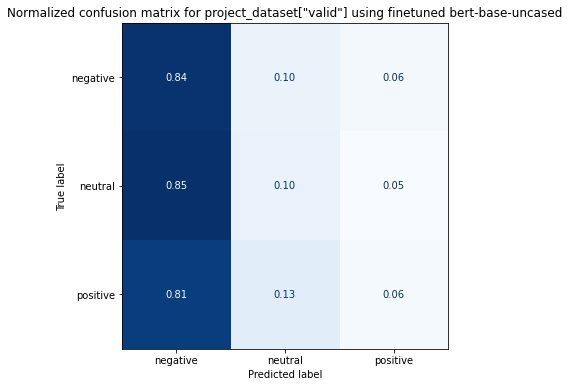

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1301
  Batch size = 8





Classification report for project_dataset["valid"] using finetuned bert-base-uncased
---------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.32      0.84      0.47      1791
     neutral       0.42      0.10      0.16      2494
    positive       0.25      0.06      0.10      1275

    accuracy                           0.33      5560
   macro avg       0.33      0.33      0.24      5560
weighted avg       0.35      0.33      0.25      5560

---------------------------------------------------------------------------


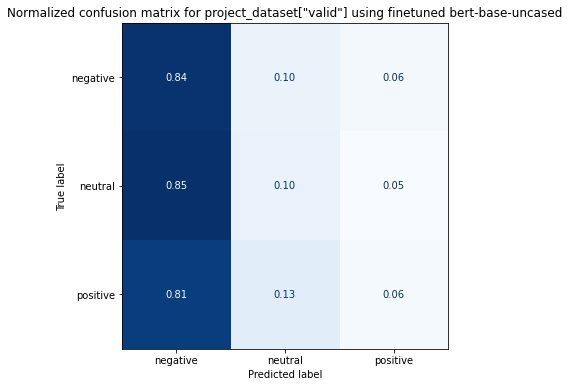




Classification report for project_dataset["valid"] using finetuned bert-base-uncased
---------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.40      0.88      0.55       504
     neutral       0.27      0.08      0.12       384
    positive       0.34      0.06      0.11       413

    accuracy                           0.39      1301
   macro avg       0.34      0.34      0.26      1301
weighted avg       0.34      0.39      0.28      1301

---------------------------------------------------------------------------


In [19]:
y_valid = np.array(dataset_encoded["valid"]["label"])
validation_predictions_all = trainer.predict(dataset_encoded["valid"])
y_preds_v = np.argmax(validation_predictions_all.predictions, axis=1)
print_classification_report(y_preds_v, y_valid, "project_dataset[\"valid\"] using finetuned " + model_checkpoint)

y_test = np.array(dataset_encoded["test"]["label"])
test_predictions_all = trainer.predict(dataset_encoded["test"])
y_preds_t = np.argmax(test_predictions_all.predictions, axis=1)
print_classification_report(y_preds_t, y_test, "project_dataset[\"test\"] using finetuned " + model_checkpoint)

2.3.2.5 Loading saved model and testing performance on test data

Didn't find file /content/best_models/bert-base-uncased/added_tokens.json. We won't load it.
loading file /content/best_models/bert-base-uncased/vocab.txt
loading file /content/best_models/bert-base-uncased/tokenizer.json
loading file None
loading file /content/best_models/bert-base-uncased/special_tokens_map.json
loading file /content/best_models/bert-base-uncased/tokenizer_config.json
loading configuration file /content/best_models/bert-base-uncased/config.json
Model config BertConfig {
  "_name_or_path": "/content/best_models/bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.3,
  "classifier_dropout": 0.3,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2":

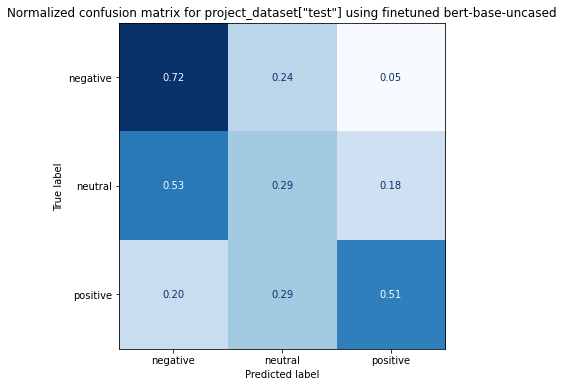




Classification report for project_dataset["test"] using finetuned bert-base-uncased
---------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.56      0.72      0.63       504
     neutral       0.32      0.29      0.30       384
    positive       0.69      0.51      0.59       413

    accuracy                           0.53      1301
   macro avg       0.52      0.51      0.51      1301
weighted avg       0.53      0.53      0.52      1301

---------------------------------------------------------------------------


In [35]:
def evaluate_test_data_using_saved_model(dataset):
  # Load model
  model_load_path = working_dir +  "/best_models/" + model_checkpoint 
  loaded_tokenizer = AutoTokenizer.from_pretrained(model_load_path)
  loaded_m = (AutoModelForSequenceClassification.from_pretrained(model_load_path, num_labels=3).to(device))
  trainer = ProjectTrainer(model=loaded_m)

  dataset_encoded = encode_dataset(loaded_tokenizer, dataset)
  y_test = np.array(dataset_encoded["label"])
  labels = dataset.features["label"].names

  test_predictions_all = trainer.predict(dataset_encoded)
  y_preds_t = np.argmax(test_predictions_all.predictions, axis=1)
  print_classification_report(y_preds_t, y_test, "project_dataset[\"test\"] using finetuned " + model_checkpoint)

evaluate_test_data_using_saved_model(project_dataset["test"])